# Capstone Project: Text Summarization using machine learning techniques

In this notebook we will explore the dataset, analyze the main features and characteristics and visualize some figures to help us unsderstand how our dataset looks like and how can we process it for a better performance of our algorithms.
We will apply and use some commons techniques on data exploration and visualization.

## Exploratory Data Analysis
We can read this concept definition on Wikipedia: **"exploratory data analysis (EDA) is an approach to analyzing data sets to summarize their main characteristics, often with visual methods."**. This step is absolutely necessary and has a huge impact on the final result of a model, this analysis will tell us what type of transformation we need to apply on the dataset.


### Importing the libraries

For the very first time, we need to download and install the following libraries that we will use to plot and visualize some interesting resutls

In [1]:
#!pip install wordcloud
#!pip install gensim
#!pip install pyLDAvis

In [108]:
#Imports of all the packages needed
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
# Import the seaborn library, it is a powerful library for plotting and commonly used with matplotlib
import seaborn as sns
sns.set_style("white")
# Import utility functions
import os
import random
from collections import Counter

#Import packages to manipulate and transform the text
import re, string
import nltk
from nltk.tokenize import word_tokenize
import gensim
from gensim.summarization.textcleaner import split_sentences

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')

# Import the wordcloud library
from wordcloud import WordCloud

# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer

# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
#Import a package to manage the warnings and ignore them
import warnings
warnings.simplefilter("ignore", DeprecationWarning)


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [3]:
# Import a library to apply LDA analysis on data
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis

We will define some global variables to be use during our analysis:

In [4]:
#Set the path where the datafiles are stored
data_path = 'MLE_Capstone_Text_Summarization/data/'
data_filename='news_summary.csv'
output_path='MLE_Capstone_Text_Summarization/data_analysis/'

#Define some global variables for text processing
punc = string.punctuation
#Create the list of stopwords
stopwords = nltk.corpus.stopwords.words('english')

### Loading the dataset
First step, load the whole dataset hosted locally

In [6]:
# Run only for the first time or when new datafiles have been stored in GS
#%%bash
#gsutil cp gs://mlend_bucket/data/news_summary/news_summary_more.csv ../data/

Copying gs://mlend_bucket/data/news_summary/news_summary_more.csv...
- [1 files][ 39.5 MiB/ 39.5 MiB]                                                
Operation completed over 1 objects/39.5 MiB.                                     


In [8]:
# Load the data from the file system
summary = pd.read_csv(data_path + data_filename, encoding='iso-8859-1')
summary.head(5)

,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in...,http://www.hindustantimes.com/india-news/raksh...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorc...,http://www.hindustantimes.com/bollywood/malaik...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,Arshiya Chopra,"03 Aug 2017,Thursday",'Virgin' now corrected to 'Unmarried' in IGIMS...,http://www.hindustantimes.com/patna/bihar-igim...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Sumedha Sehra,"03 Aug 2017,Thursday",Aaj aapne pakad liya: LeT man Dujana before be...,http://indiatoday.intoday.in/story/abu-dujana-...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Aarushi Maheshwari,"03 Aug 2017,Thursday",Hotel staff to get training to spot signs of s...,http://indiatoday.intoday.in/story/sex-traffic...,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


When searching for information and data about text summarization I found hard to obtain a "good" dataset. Some of the most popular data sets are intended for research use, containing hundreds of thousands of examples and gigabytes of data that require high computational capacity and days or weeks to train. But we are interested in a dataset that could be trained faster, in a few hours, where we can experiment and develop easily.
We will use a dataset from Kaggle, [4], that consists in two diferentes files:
- One containing 4515 examples of news and their summaries and some extra data like Author_name, Headlines, Url of Article, Short text, Complete Article. This dataset has longer texts, the summaries are about 60-word length and texts are 300-400 words each.
- Anothe file has about 98,000 records with shorter summaries, about 20 words, and the text are 80-150 word length.

This data was extracted from Inshorts, scraping the news article from Hindu, Indian times and Guardian. 

An example:
- Text: "Isha Ghosh, an 81-year-old member of Bharat Scouts and Guides (BSG), has been imparting physical and mental training to schoolchildren ..."
- Summary: "81-yr-old woman conducts physical training in J'khand schools"
For a better performance, we should consider using a greater dataset like the CNN dataset that contains more than 93,000 news articles.



Lets show an example of the dataset

In [7]:
print(summary['headlines'][0],'\n',summary['text'][0],'\n',summary['ctext'][0])

Daman & Diu revokes mandatory Rakshabandhan in offices order 
 The Administration of Union Territory Daman and Diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on the occasion of Rakshabandhan on August 7. The administration was forced to withdraw the decision within 24 hours of issuing the circular after it received flak from employees and was slammed on social media. 
 The Daman and Diu administration on Wednesday withdrew a circular that asked women staff to tie rakhis on male colleagues after the order triggered a backlash from employees and was ripped apart on social media.The union territory?s administration was forced to retreat within 24 hours of issuing the circular that made it compulsory for its staff to celebrate Rakshabandhan at workplace.?It has been decided to celebrate the festival of Rakshabandhan on August 7. In this connection, all offices/ departments shall remain open and celebrate the festival collectively at a sui

So our first strep is to get a simple view of the number of registries: 

In [9]:
# Count the number of examples and unique values
print('Dataset examples: ', len(summary))
summary.describe()

Dataset examples:  4514


,author,date,headlines,read_more,text,ctext
count,4514,4514,4514,4514,4514,4396
unique,45,240,4514,4461,4514,4341
top,Chhavi Tyagi,"19 Jul 2017,Wednesday",Airbnb host who cancelled stay over guest's ra...,http://indiatoday.intoday.in/story/assembly-el...,An allegedly drunk man on Friday strangled a s...,AAJ TAK LIVE TV WITH LIVE ELECTION RESULTS I c...
freq,559,76,1,13,1,13


We can observe that there are three variables describing the text of the news:
- ctext: this is the longest variable and contains the full text of the news
- text: this is a summary composed by two or three sentences
- Headlines: this is the highlight or headline of the news

In our project we will work with the ctext variable as the text feature and the text variable will be our target summary.

Reading the previous table we can observe that there are some rows with a null value in the variable ctext. So our first step would be to drop those rows and duplicate ones. 

In [10]:
#Remove duplicates on the ctext 
summary.drop_duplicates(subset=["ctext"],inplace=True)
#Remove rows containing null values
summary.dropna(inplace=True)
#Recreate the dataframe index
summary.reset_index(drop=True,inplace=True)
summary.describe()

,author,date,headlines,read_more,text,ctext
count,4341,4341,4341,4341,4341,4341
unique,45,240,4341,4341,4341,4341
top,Chhavi Tyagi,"19 Jul 2017,Wednesday",Use social media to promote welfare schemes: P...,http://indiatoday.intoday.in/story/kerala-sani...,An allegedly drunk man on Friday strangled a s...,"Raipur, May 14 (PTI) At least 213 HIV-infected..."
freq,537,76,1,1,1,1


Our problem is not interested in any others variables except the text or full text of the article and the corresponding summary, so we can remove the Author, Date, etc.

Lets create a new dataframe with the variables we are interested in analyzing.

In [11]:
# we are using the text variable as the summary and the ctext as the source text
dataset = summary[['text','ctext']].copy()
dataset.columns = ['summary','text']
dataset.head(5)

,summary,text
0,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


## Data exploratory analysis
The dataset contains only the two columns of interest - summary and text. In this section we will create some some additional features that provide relevant information about the composition of our texts. The following list explains different ideas for creating new features:

#### Statistical Count Features from headlines and text
- Sentence Count - Total number of sentences in the text
- Word Count - Total number of words in the text
- Character Count - Total number of characters in the text excluding spaces
- Sentence density - Number of setences relative to the number of words
- Word Density - Average length of the words used in the headline
- Punctuation Count - Total number of punctuations used in the headline
- Stopwords Count - Total number of common stopwords in the text


Lets define some helpers function 

In [13]:
def count_stopwords(text, stopwords):
    ''' Return the number of stopwords in the text
        Input:
            - text: string
            - stopwords: list of string, containing the stopwords
        Output:
            - int, number of stopwords in the text argument
    '''
    word_tokens = word_tokenize(text) #splitta i pezzi
    stopwords_x = [w for w in word_tokens if w in stopwords]
    
    return len(stopwords_x)

It is time to calculate every new feature previously listed. 

In [14]:
# Create a new variable containing the number of sentences in the summary
dataset['sum_sent_count'] = dataset['summary'].apply(lambda x : len(split_sentences(x)))
# Create a new variable containing the number of sentences in the text
dataset['text_sent_count'] = dataset['text'].apply(lambda x : len(split_sentences(x)))
# Create a new variable containing the number of word in the summary
dataset['sum_word_count'] = dataset['summary'].apply(lambda x : len(x.split()))
# Create a new variable containing the number of word in the text
dataset['text_word_count'] = dataset['text'].apply(lambda x : len(x.split()))
# Create a new variable containing the number of characters in the summary
dataset['sum_char_count'] = dataset['summary'].apply(lambda x : len(x.replace(" ","")))
# Create a new variable containing the number of characters in the text
dataset['text_char_count'] = dataset['text'].apply(lambda x : len(x.replace(" ","")))
# Create a new variable containing the density of words in the summary
dataset['sum_word_density'] = dataset['sum_word_count'] / (dataset['sum_char_count'] + 1)
# Create a new variable containing the density of words in the text
dataset['text_word_density'] = dataset['text_word_count'] / (dataset['text_char_count'] + 1)
# Create a new variable containing the density of sentences in the summary
dataset['sum_sent_density'] = dataset['sum_sent_count'] / (dataset['sum_word_count'] + 1)
# Create a new variable containing the density of sentences in the text
dataset['text_sent_density'] = dataset['text_sent_count'] / (dataset['text_word_count'] + 1)
# Create a new variable containing the number of punctuations in the summary
dataset['sum_punc_count'] = dataset['summary'].apply(lambda x : len([a for a in x if a in punc]))
# Create a new variable containing the number of punctuations in the text
dataset['text_punc_count'] = dataset['text'].apply(lambda x : len([a for a in x if a in punc]))

# Stopwords
# Create a new variable containing the number of stopwords in the text
dataset['text_stopw_count'] =  dataset['text'].apply(lambda x : count_stopwords(x, stopwords))
# Create a new variable containing the number of stopwords in the summary
dataset['sum_stopw_count'] =  dataset['summary'].apply(lambda x : count_stopwords(x, stopwords))
# Create a new variable containing the density of stopwords in the summary
dataset['sum_stopw_density'] = dataset['sum_stopw_count'] / (dataset['sum_word_count'] + 1)
# Create a new variable containing the density of stopwords in the text
dataset['text_stopw_density'] = dataset['text_stopw_count'] / (dataset['text_word_count'] + 1)

#Print some of the calculated values
print(dataset[['sum_word_count', 'sum_char_count', 'sum_word_density', 'sum_punc_count']].head(5))
print(dataset[['text_word_count', 'text_char_count', 'text_word_density', 'text_punc_count']].head(5))
print(dataset[['text_sent_count', 'sum_sent_count', 'text_sent_density', 'sum_sent_density']].head(5))
print(dataset[['text_stopw_count', 'sum_stopw_count', 'text_stopw_density', 'sum_stopw_density']].head(5))

   sum_word_count  sum_char_count  sum_word_density  sum_punc_count
0              60             299          0.200000               2
1              60             302          0.198020              21
2              60             339          0.176471              12
3              60             309          0.193548              23
4              60             307          0.194805               8
   text_word_count  text_char_count  text_word_density  text_punc_count
0              364             1950           0.186571               55
1              396             1981           0.199798               84
2              335             1780           0.188097               53
3              404             1981           0.203835               87
4              526             2724           0.193028               62
   text_sent_count  sum_sent_count  text_sent_density  sum_sent_density
0               14               2           0.038356          0.032787
1               

### Analyze the distribution of the text variable

Now that we have calculated the new features, we can analyze the descriptive statistics to identify outliers or distribution 

In [15]:
dataset[['text_sent_count', 'text_word_count', 'text_char_count', 'text_stopw_count', 'text_punc_count']].describe()


,text_sent_count,text_word_count,text_char_count,text_stopw_count,text_punc_count
count,4341.000000,4341.000000,4341.000000,4341.000000,4341.000000
mean,12.970974,337.573140,1713.334716,132.756047,58.908546
std,23.600000,343.945806,1754.699138,136.731540,81.742324
min,1.000000,1.000000,3.000000,0.000000,0.000000
25%,5.000000,185.000000,935.000000,68.000000,28.000000
50%,9.000000,281.000000,1429.000000,109.000000,44.000000
75%,15.000000,407.000000,2060.000000,162.000000,68.000000
max,687.000000,12202.000000,63845.000000,4498.000000,1889.000000


Summarizing:
- 12 sentences, 337 words and 1713 characters per text are the mean values
- But we observe that the maximum number of sentences (687) or chars (more than 63,000) are far away from the mean values, indicating that there are some registers with values out of range or outliers. 

Let’s dive in these features to get a better understanding:

**Plotting box plots and histograms about text variable**

In [87]:
# We declare a new dataframe for plotting porpouses
#data=dataset

# Create a dictionary to title the columns based on their names
labels_dict={'sum_word_count': 'Word Count of Summaries','text_word_count': 'Word Count of Texts',
             'sum_char_count': 'Char Count of Summaries','text_char_count': 'Char Count of Texts',
             'sum_word_density': 'Word Density of Summaries','text_word_density': 'Word Density of Texts',
             'sum_punc_count': 'Punctuation Count of Summaries','text_punc_count': 'Punctuation Count of Texts',
             'text_sent_count': 'Sentence Count of Texts', 'sum_sent_count': 'Sentence Count of Summaries',
             'text_sent_density': 'Sentence Density of Texts', 'sum_sent_density': 'Sentence Density of Summaries',
             'text_stopw_count': 'Stopwords Count of Texts', 'sum_stopw_count': 'Stopwords Count of Summaries',
             'ADJ': 'adjective','ADP': 'adposition', 'ADV': 'adverb','CONJ': 'conjunction',
             'DET': 'determiner','NOUN': 'noun', 'text_unknown_count': 'Unknown words in Texts',
             'sum_unknown_count': 'Unknown words in Summaries',}

Define some functions to plot our graphics or figures:

In [89]:
def plot_boxplots(data, plot_vars, labels, figsize):
    ''' Plot a box-plot of the variables in the plot_vars list using the labels and a size of figesize
        Input:
        - data: a dataframe, containing the data points to plot
        - plot_vars: a (1,x) array, containig the columns to plot
        - labels: a dctionary, to map the column names to its label
        - figsize: a tuple, indicating the size of the figure
    '''
    
   # We need to identify is this a matrix or a vector
    if plot_vars.ndim == 1:
        nrows=1
        ncols = plot_vars.shape[0]
    else:
        nrows= plot_vars.shape[0]
        ncols = plot_vars.shape[1]

    #Create a figure and its axes for the dimensions defined
    f, axes = plt.subplots(nrows, ncols, sharey=False, figsize=(15,5))
    #For every variable in the plot_vars
    for i in range(nrows):
        for j in range(ncols):
            # If the column name is defined we plot it
            if plot_vars[i,j]!=None:
                if axes.ndim>1:
                    #Set the title
                    axes[i,j].set_title(labels[plot_vars[i,j]])
                    axes[i,j].grid(True)
                    #Set x ticks
                    axes[i,j].tick_params(
                        axis='x',          # changes apply to the x-axis
                        which='both',      # both major and minor ticks are affected
                        bottom=False,      # ticks along the bottom edge are off
                        top=False,         # ticks along the top edge are off
                        labelbottom=False)
                    # Plot a boxplot for the column in plot_vars
                    axes[i,j].boxplot(data[plot_vars[i,j]])
                else:
                    #Set the title
                    axes[j].set_title(labels[plot_vars[i,j]])
                    axes[j].grid(True)
                    #Set x ticks
                    axes[j].tick_params(
                        axis='x',          # changes apply to the x-axis
                        which='both',      # both major and minor ticks are affected
                        bottom=False,      # ticks along the bottom edge are off
                        top=False,         # ticks along the top edge are off
                        labelbottom=False)
                    # Plot a boxplot for the column in plot_vars
                    axes[j].boxplot(data[plot_vars[i,j]])
                
            else:
                axes[i,j].set_visible(False)
    # Adjust the plots for a better visualization
    f.tight_layout()
    plt.show() 


def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

def plot_histograms(data, plot_vars, xlim, labels, figsize):
    ''' Function to plot the histograms of the variables in plot_vars
        Input:
        - data: a dataframe, containing the data points to plot
        - plot_vars: a (1,x) array, containig the columns to plot
        - xlim: a list, define the max x value for every column to plot
        - labels: a dctionary, to map the column names to its label
        - figsize: a tuple, indicating the size of the figure
    '''
    #Set some parameters
    kwargs = dict(hist_kws={'alpha':.7}, kde_kws={'linewidth':2})

    #cmap = get_cmap(plot_vars.shape[1])
    # Create the figure and axes
    fig, axes = plt.subplots(plot_vars.shape[0], plot_vars.shape[1], figsize=figsize, sharey=False, dpi=100)
    #For every variable in plot_vars
    for i in range(plot_vars.shape[1]):
        # Plot the histogram 
        sns.distplot(data[plot_vars[0,i]] , color=(random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1),), 
                     ax=axes[i], axlabel=labels[plot_vars[0,i]], bins= 50, norm_hist = True)
        #For a better visualization we set the x limit
        axes[i].set_xlim(left=0, right=xlim[i])
        
    fig.tight_layout()

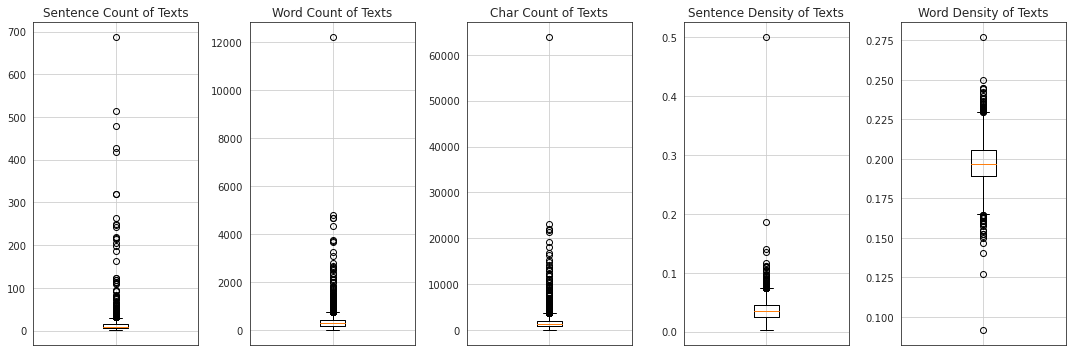

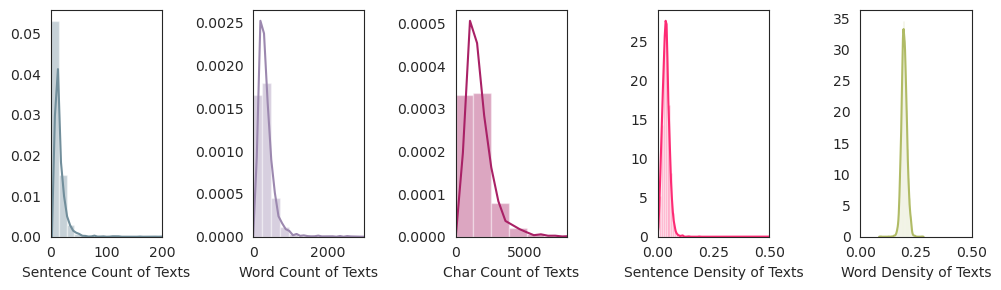

In [90]:
#Set the columns to plot
plot_vars=np.array([['text_sent_count', 'text_word_count', 'text_char_count','text_sent_density','text_word_density']])
# Plot the boxplots for the interesting columns
plot_boxplots(dataset, plot_vars, labels_dict, figsize=(10,3))
# Plot the histograms 
plot_histograms(dataset, plot_vars, [200, 3000, 8000, 0.5, 0.5], labels_dict, figsize=(10,3))

Above we have plotted the histograms of our features. We can confirm that although most of the variables show their peak at low values ​​we see that there are examples with much higher values 

### Analyzing the distribution of the summary variable

In [91]:
# Extract the descriptive statistics for the summary variable
dataset[['sum_word_count', 'sum_char_count', 'sum_sent_count', 'sum_sent_density', 'sum_word_density']].describe()

,sum_word_count,sum_char_count,sum_sent_count,sum_sent_density,sum_word_density
count,4341.000000,4341.000000,4341.000000,4341.000000,4341.000000
mean,58.297858,297.426860,2.824234,0.047648,0.196331
std,2.304367,23.049156,0.673544,0.011304,0.014742
min,44.000000,227.000000,1.000000,0.016393,0.152738
25%,57.000000,282.000000,2.000000,0.036364,0.185759
50%,59.000000,298.000000,3.000000,0.049180,0.195440
75%,60.000000,314.000000,3.000000,0.050847,0.205674
max,62.000000,346.000000,6.000000,0.111111,0.258772


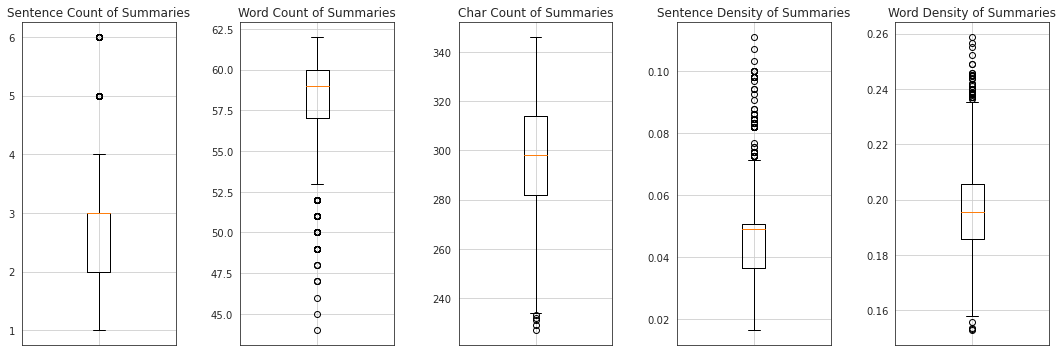

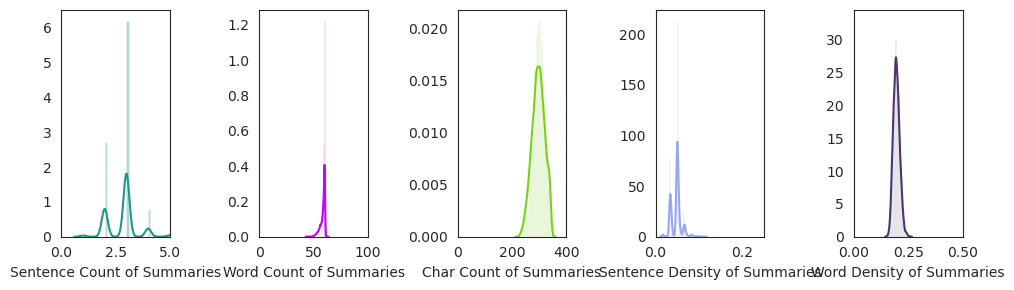

In [92]:
#Set the columns to plot
plot_vars=np.array([['sum_sent_count', 'sum_word_count', 'sum_char_count','sum_sent_density','sum_word_density']])
# Plot the boxplots and histograms for the interesting columns
plot_boxplots(dataset, plot_vars, labels_dict, figsize=(10,3))
plot_histograms(dataset, plot_vars, [5, 100, 400, 0.25, 0.5], labels_dict, figsize=(10,3))

Now, there are no outliers of registries with values out of range. The distribution of words and sentence are close to the mean value and the standard deviation is relatively small.
- Most summaries are composed by 2 or 3 sentences and the number of words is very close to 60.
- The number of chars are around 300

### Categorizing and Tagging Words

*The process of classifying words into their parts of speech and labeling them accordingly is known as part-of-speech tagging, POS-tagging, or simply tagging. Parts of speech are also known as word classes or lexical categories.* The collection of tags used for a particular task is known as a tagset. Our emphasis in the next section is on exploiting tags, and tagging text automatically.

Tag Meaning English Examples:
- ADJ, adjective: new, good, high, special, big, local
- ADP,adposition:on, of, at, with, by, into, under
- ADV, adverb: really, already, still, early, now
- CONJ, conjunction: and, or, but, if, while, although
- DET, determiner or article: the, a, some, most, every, no, which
- NOUN, noun: year, home, costs, time, Africa
- NUM,numeral: twenty-four, fourth, 1991, 14:24
- PRT, particle: at, on, out, over per, that, up, with
- PRON, pronoun: he, their, her, its, my, I, us
- VERB, verb: is, say, told, given, playing, would
- ., punctuation marks:. , ; !
- X, othe: ersatz, esprit, dunno, gr8, univeristy

In [93]:
def get_pos_tags(sentences, tagset='universal'):
    ''' Extract the part-of-speech taggings of the sentence
        Input:
        - sentence: string, sentence to tag
        - tagset: string, tagset or the set of tags to search for
    '''
    #Create the Dataframe to store the count of tags
    df = pd.DataFrame(columns=['ADJ','ADP','ADV','CONJ','DET','NOUN','NUM','PRT','PRON','VERB','.','X'])
    for sent in sentences:
        # Extract the part of Speech tags in the sentence
        pos_tags = Counter([j for i,j in nltk.pos_tag(word_tokenize(sent), tagset='universal')])
        #Appends the pos tags to the dataframe, fill NaN values with 0
        df = df.append(pos_tags, ignore_index=True).fillna(0)

    return df.astype(int)

Extract the part of speech tags for the text and summary variables:

In [94]:
# Identify the taggings for the text variable
news_text = dataset['text'].values
df_text = get_pos_tags(news_text)
# Identify the taggings for the summary variable
news_summary = dataset['summary'].values
df_summary = get_pos_tags(news_summary)

df_summary.head()

,ADJ,ADP,ADV,CONJ,DET,NOUN,NUM,PRT,PRON,VERB,.,X
0,2,11,1,2,5,19,2,3,4,11,2,0
1,2,6,4,2,5,19,0,2,8,16,16,0
2,4,8,3,1,5,25,0,3,2,10,9,0
3,1,5,1,1,1,24,0,2,9,16,19,2
4,3,7,1,1,4,24,0,2,1,17,7,0


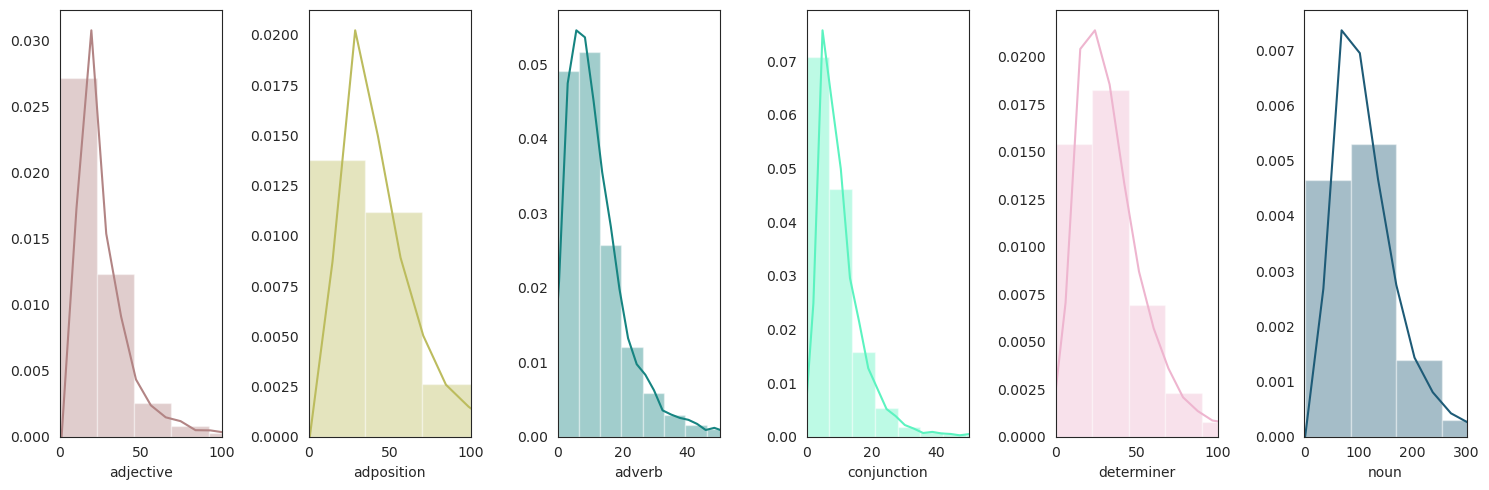

In [95]:
# Select the columns to plot: those related to pos taggings
plot_vars=np.array([['ADJ','ADP','ADV','CONJ','DET','NOUN']])
# Plot a histograms of the variables 
plot_histograms(df_text, plot_vars, [100, 100, 50, 50, 100, 300], labels_dict, figsize=(15,5))

### Check for unknown words

The unknown words in a text is a issue with need to deal with, so we will analyze the ocurrencies of unknown words in aour variables. Most of them are people names, surnames but there are some misspelled words.

In [96]:
class GloveVectorizer:
  '''Class to store the vocabulary of our texts, including mappings between words and its integer representation. 
     It also contain the embeddings of the vocab to transform every token or integer value
  '''
  def __init__(self, embedding_file):
    ''' Build the embeddings, load them from a file and store it in a list of embedded vectors '''
    # load in pre-trained word vectors
    print('Loading word vectors...')
    word2vec = {}
    embedding = []
    idx2word = []
    with open(embedding_file) as f:
      # is just a space-separated text file in the format:
      # word vec[0] vec[1] vec[2] ...
      for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
        embedding.append(vec)
        idx2word.append(word)
    print('Found %s word vectors.' % len(word2vec))

    # save for later
    self.word2vec = word2vec
    self.embedding = np.array(embedding)
    self.word2idx = {v:k for k,v in enumerate(idx2word)}
    self.V, self.D = self.embedding.shape

  def fit(self, data):
    pass

  def transform(self, data):
    ''' Include the tokens contained in the data in the vocabulary'''
    X = np.zeros((len(data), self.D))
    n = 0
    emptycount = 0
    # For every sentence in the data
    for sentence in data:
      tokens = sentence.lower().split() # Extract the words
      vecs = []
      unknowns=0
      # For every word in the setence
      for word in tokens:
        # Include the embedded word in the output list 
        if word in self.word2vec:
          vec = self.word2vec[word]
          vecs.append(vec)
        else:
          unknowns += 1  
      # Calculate the embedding of a data as the mean of the embeddings of every word 
      if len(vecs) > 0:
        vecs = np.array(vecs)
        X[n] = vecs.mean(axis=0)
      else:
        emptycount += 1
      n += 1
    #print("Numer of samples with no words found: %s / %s" % (emptycount, len(data)))
    return X

  def fit_transform(self, data):
    self.fit(data)
    return self.transform(data)


In [97]:
def replace_punctuation(text, punctuation):
    ''' Replace punctuation with whitespace'''
    table=str.maketrans(punctuation, ' '*len(punctuation))
    return text.translate(table)

def unknown_words(text, vocab):
    ''' Return the unknow words found in the text, those not found in the embeddings '''
    tokens = word_tokenize(text)
    unknown = [t for t in tokens if t not in vocab.word2vec]
    
    return unknown


In [98]:
# Set the filename containing the embeddings
glove_file = 'glove.6B.100d.txt'
glove_filename = os.path.join(data_path, glove_file)
#Load the Glove embeddings
vectorizer = GloveVectorizer(glove_filename)

Loading word vectors...
Found 400000 word vectors.


In [99]:
# Clean the text to tokenize and extract the unknown words
dataset['text_unknown_words'] = dataset['text'].apply(lambda x : replace_punctuation(x.lower(), string.punctuation))
dataset['text_unknown_words'] = dataset['text_unknown_words'].apply(lambda x : unknown_words(x, vectorizer))
# Count the ocurrencies of unknown words in the text
dataset['text_unknown_count'] = dataset['text_unknown_words'].apply(lambda x : len(x))

In [100]:
# Clean the summary to tokenize and extract the unknown words
dataset['sum_unknown_words'] = dataset['summary'].apply(lambda x : replace_punctuation(x.lower(), string.punctuation))
dataset['sum_unknown_words'] = dataset['sum_unknown_words'].apply(lambda x : unknown_words(x, vectorizer))
# Count the ocurrencies of unknown words in the summary
dataset['sum_unknown_count'] = dataset['sum_unknown_words'].apply(lambda x : len(x))

We can show the distribution of the unknown words in our texts to get a fast insight of their relevance:

In [101]:
# Extract the descriptive statistics for the summary variable
dataset[['text_unknown_count', 'sum_unknown_count']].describe()

,text_unknown_count,sum_unknown_count
count,4341.000000,4341.000000
mean,5.820779,0.617600
std,12.495829,1.041226
min,0.000000,0.000000
25%,1.000000,0.000000
50%,3.000000,0.000000
75%,7.000000,1.000000
max,469.000000,8.000000


Some examples of unknown words:

In [102]:
print('Unknown words: ', dataset['text_unknown_words'].values[5])
print('Unknown words: ', dataset['text_unknown_words'].values[50])
print('Unknown words: ', dataset['text_unknown_words'].values[100])

Unknown words:  ['jahangirpuri', 'pitampura', 'jahangirpuri', 'vijayanta']
Unknown words:  ['landaura', 'manikant', 'brahmpal']
Unknown words:  ['25pm', '22pm']


Lets plot some histograms to observe how the distribution of unknown words looks like

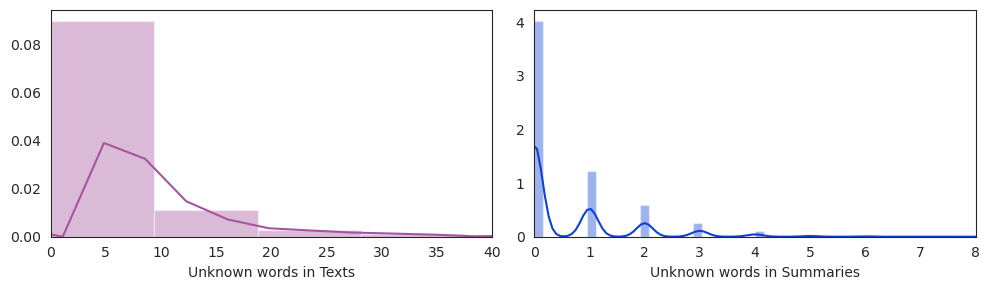

In [103]:
# Set the columns to plot, the unknown words in the text and summary
plot_vars=np.array([['text_unknown_count', 'sum_unknown_count']])
# Plot the histograms
plot_histograms(dataset, plot_vars, [40, 8], labels_dict, figsize=(10,3))

- In our source texts the mean is 5 and 70% of the sentences are below 5. About 8% of the words in the texts are unknown it is high enough to be very careful on its treatment.
- The figures are 0.5 and 1 in the case of the summary variable, they are not relevant.


### Use of stopwords and punctuations


Now that we have a more accurate vision of the composition of our texts we need to analyze the use of stopwords and punctuation, this analysis will indicate us if these "special type" of characters will be removed or transform when we train our models.  

Now, lets explore the histograms (What is a hist) of the valculated variables, to get a better intuition about the texts we are goind to deal with.

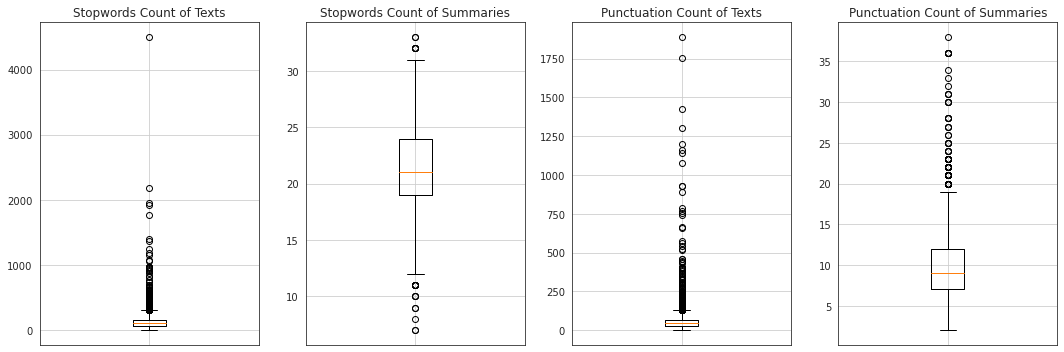

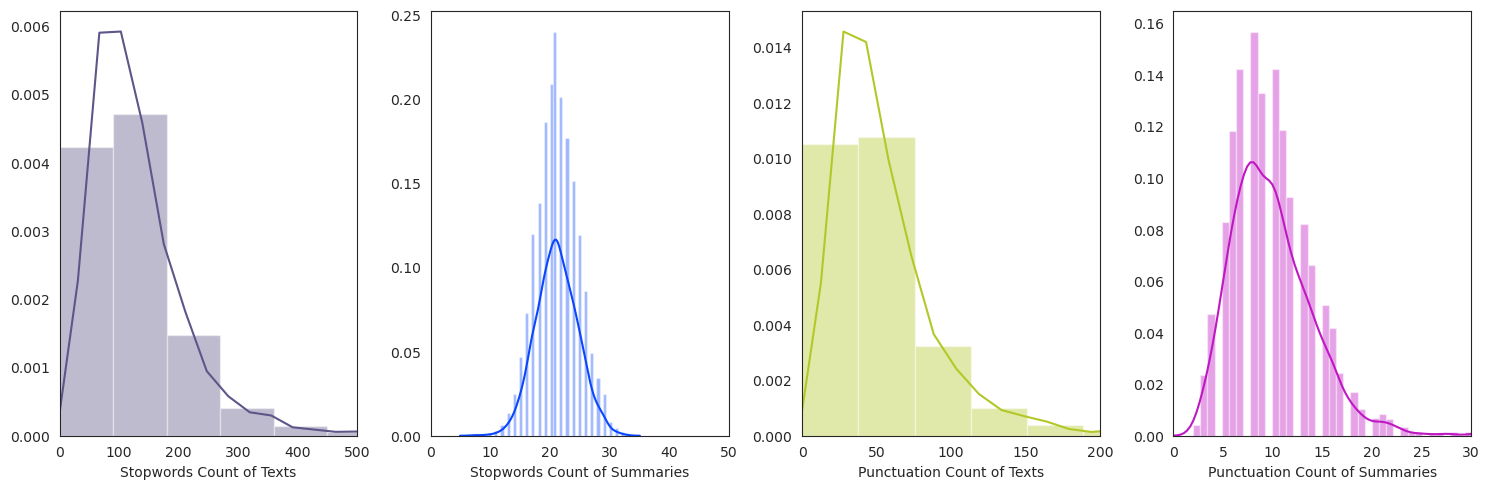

In [105]:
# Set the columns to plot, those relatives to stopwords and punctuation
plot_vars=np.array([['text_stopw_count', 'sum_stopw_count', 'text_punc_count','sum_punc_count']])
# Plot the bosplot and histograms
plot_boxplots(data, plot_vars, labels_dict, figsize=(15,5))
plot_histograms(data, plot_vars, [500, 50, 200, 30], labels_dict, figsize=(15,5))

### Cleaning the data

Next, let’s perform a simple preprocessing on the content of the text column to make them more amenable for analysis, and reliable results. To do that, we’ll remove any punctuation, digit and then lowercase the text

In [106]:
def clean_text(text, stopwords):
    ''' Apply some basic techniques for cleaning a text for an analysis of words
    
    Input:
       - text: text to be cleaned
    Output:
       - result: cleaned text
    '''
    # Lowercase the text
    text = text.lower()
    # Remove any  non-alphabet characters including digits
    pattern =  r'[^a-zA-Z\s]'    
    text = re.sub(pattern, '', text)
    # Remove punctuation
    #table=str.maketrans('','',string.punctuation)
    #text = text.translate(table)
    # Remove the stopwords    
    tokens = nltk.word_tokenize(text)    
    tokens = [token.strip() for token in tokens]    
    text = ' '.join([token for token in tokens if token not in stopwords])
    return text

### Wordclouds for summary and text
A Wordcloud (or Tag cloud) is a visual representation of text data. It displays a list of words, the importance of each beeing shown with font size or color (the bigger the more frequent). This format is useful for quickly perceiving the most relevant terms on a document or set of documents.
We will draw the wordcloud for the source texts and the summaries to compare if they are very similar, it will allow us to check that the relevant concepts have been correctly extracted in the summaries.

Before building the wordclouds we need to do some basic cleaning in the dataset.

In [107]:
#Clean the source text and te summary in our dataset
cleaned_summary = dataset['summary'].apply(lambda x : clean_text(x,stopwords))
cleaned_text = dataset['text'].apply(lambda x : clean_text(x, stopwords))

Build the wordcloud for source texts

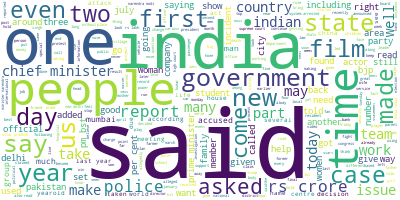

In [109]:
# Join the different processed texts together.
long_string = ','.join(list(cleaned_text.values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

Now it is time to build the Cloud of Words for the summaries

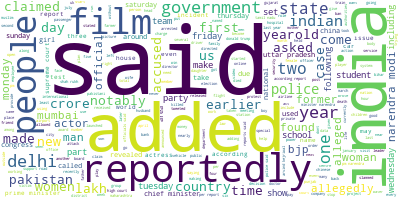

In [84]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(cleaned_summary.values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

As it could be expected they both contain almost the same words: said, people, india, film, asked, year. Except goverment and time that are very frequent in the source text while added and reportedly appears a lot of times in the summary.

### Topic Modelling

In this post, we will learn how to identity which topic is discussed in a document, called topic modelling. In particular, we will cover Latent Dirichlet Allocation (LDA): a widely used topic modelling technique. And we will apply LDA to convert set of research papers to a set of topics.
Research paper topic modelling is an unsupervised machine learning method that helps us discover hidden semantic structures in a paper, that allows us to learn topic representations of papers in a corpus. The model can be applied to any kinds of labels on documents, such as tags on posts on the website.

Link a revisar: 
https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
Con herramientas para visualizarlos

Otro link:
https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21
Visualizacion y detalle interesante

Next, let’s work to transform the textual data in a format that will serve as an input for training LDA model. We start by converting the documents into a simple vector representation (Bag of Words BOW). Next, we will convert a list of titles into lists of vectors, all with length equal to the vocabulary.

In [110]:
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    ''' Draw a barplot showing the tenth most common words in the data
        Input:
        - count_data: tuple, containing pairs of document-term and its ocurrencies in the text
        - count_vectorizer: CountVectorizer object
    '''
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()


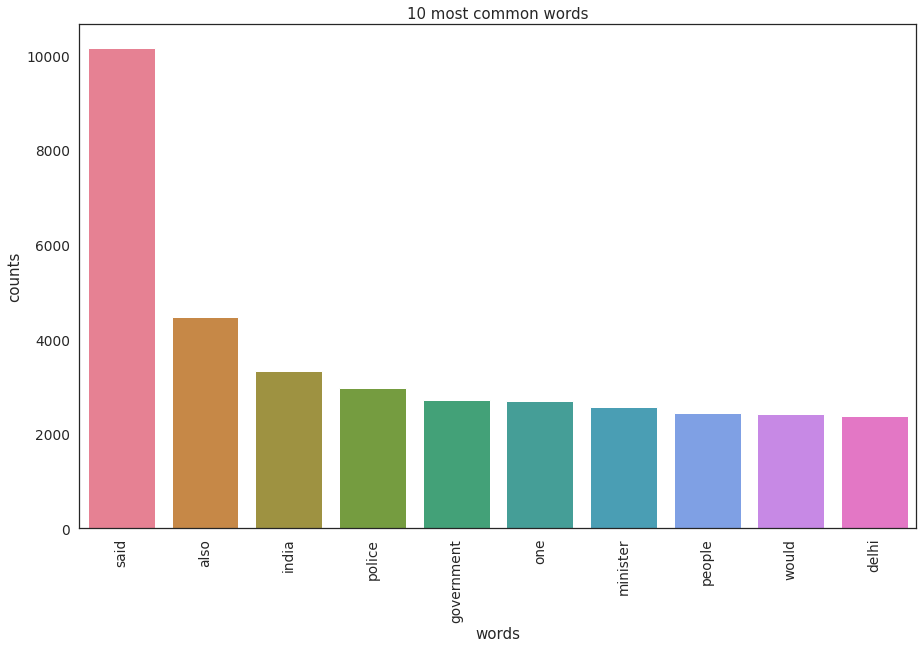

In [113]:
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer()
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(cleaned_text)
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

## Topic modelling

In machine learning and natural language processing, a topic model is a type of statistical model for discovering the abstract "topics" that occur in a collection of documents. Topic modeling is a frequently used text-mining tool for discovery of hidden semantic structures in a text body.

The next cells will allow us to discover topics in our texts, group of words with co-ocurrences in the documents.

In [115]:
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    ''' Print the topics detected and the n_top_words that contains
    Input:
       - model: LDA model for the text
       - count_cectorizer: the count vectorizer object
       - n_top_words: the number of words to consider in a topic
    '''
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))


In [116]:
# Set the main parameters to define our topic modelling
number_topics = 3
number_words = 5
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
said one film people actor

Topic #1:
india said indian also film

Topic #2:
said also police government delhi


### Visualization the topic modelling results

Now that we have a trained model let’s visualize the topics for interpretability. To do so, we’ll use a popular visualization package, pyLDAvis which is designed to help interactively with:
- Better understanding and interpreting individual topics, and
- Better understanding the relationships between the topics.

In [117]:
LDAvis_data_filepath = os.path.join(output_path+'ldavis_prepared_'+str(number_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
#if 1 == 1:

LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)
with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath,'rb') as f:
    LDAvis_prepared = pickle.load(f)
    
pyLDAvis.save_html(LDAvis_prepared, LDAvis_data_filepath+'.html')

#### Links:
https://www.kaggle.com/shivamb/seconds-from-disaster-text-eda-and-analysis

https://www.kaggle.com/caractacus/thematic-text-analysis-using-spacy-networkx